In [1]:
import os
import sys
import itertools
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr
from scipy.signal import detrend
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec

eradir = Path(os.path.expanduser('~/ERA5/'))

In [2]:
#da = xr.open_dataarray(eradir / 'olr_tropics.nc')
#da = xr.open_dataset(eradir / 'sst_nhplus.nc', group = 'mean')['sst-mean']
da = xr.open_dataarray(eradir / 'sst_nhplus.nc')

regions = pd.DataFrame({'latrange':[slice(-1.5,5.5),slice(10.75,15.25),slice(19.5,24.25)],
    'lonrange':[slice(162,169),slice(147,151.75),slice(155,161)]},
    index = pd.Index(['warm1','cold1','cold2']), dtype = 'object')

def selectregion(array: xr.DataArray, name: str):
    assert (name in regions.index), f'choose one of the region names in {regions.index}'
    return array.sel(latitude = regions.loc[name,'latrange'], longitude = regions.loc[name,'lonrange'])

def spatial_mean(array: xr.DataArray):
    stacked = array.stack({'latlon':['latitude','longitude']})
    return stacked.mean('latlon')

def annual_mean(array: xr.DataArray):
    return array.groupby(array.time.dt.year).mean()

In [3]:
warm = selectregion(da,'warm1')
cold1 = selectregion(da,'cold1')
cold2 = selectregion(da,'cold2')
components = {'w':warm.copy(),'c1':cold1.copy(),'c2':cold2.copy()}

### Visualization of chosen regions

In [4]:
corrpattern = xr.open_dataset('/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/sst_nhplus.21.corr.nc', decode_times = False)

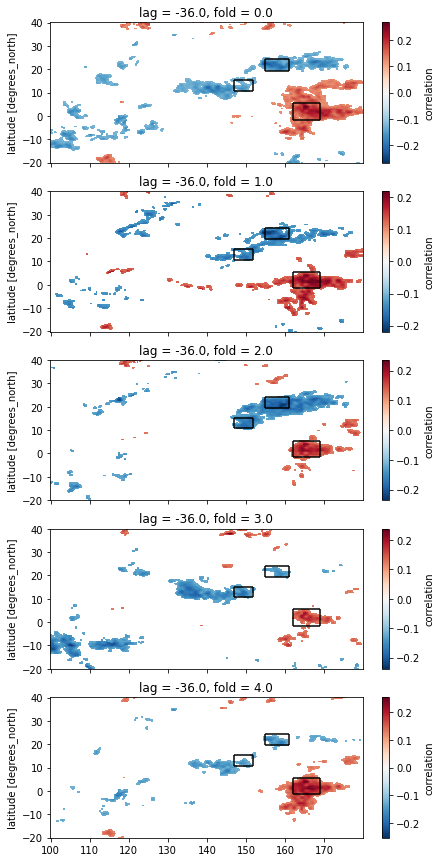

In [5]:
fig, axes = plt.subplots(nrows = 5, figsize = (7,15), sharex = True)
for i in corrpattern.coords['fold']:
    ax = axes[int(i)]
    field = corrpattern['correlation'].sel(fold = i, lag = -36)
    field.sel(latitude = slice(-20,40), longitude = slice(100,180)).plot(ax = ax)
    ax.set_xlabel('')
    for region in regions.index:
        coords = regions.loc[region,:]
        ax.hlines(y = coords['latrange'].start, xmin = coords['lonrange'].start, xmax = coords['lonrange'].stop)
        ax.hlines(y = coords['latrange'].stop, xmin = coords['lonrange'].start, xmax = coords['lonrange'].stop)
        ax.vlines(x = coords['lonrange'].start, ymin = coords['latrange'].start, ymax = coords['latrange'].stop)
        ax.vlines(x = coords['lonrange'].stop, ymin = coords['latrange'].start, ymax = coords['latrange'].stop)

### Time aggregation, Detrending, de-seasonalizing Functions

In [4]:
def agg_time(array: xr.DataArray, ndayagg: int = 1, method: str = 'mean') -> xr.DataArray:
    """
    Aggegates a daily time dimension by rolling averaging,
    Time axis should be continuous, otherwise non-neighbouring values are taken together. 
    It returns a left stamped aggregation of ndays
    Trailing Nan's are removed.
    """
    assert (np.diff(array.time) == np.timedelta64(1,'D')).all(), "time axis should be a continuous daily to be aggregated, though nan is allowed"

    name = array.name
    attrs = array.attrs
    f = getattr(array.rolling({'time':ndayagg}, center = False), method) # Stamped right
    array = f()
    array = array.assign_coords(time = array.time - pd.Timedelta(str(ndayagg - 1) + 'D')).isel(time = slice(ndayagg - 1, None)) # Left stamping, trailing nans removed
    array.name = name
    array.attrs = attrs
    return array

def fit_poly(array, degree: int = 3, year: int = None) -> xr.DataArray:
    """
    Fit 3rd order seasonal polynomial for each gridpoint in this data. 
    X is day of the year.
    Possibly for a single year, otherwise all years are joined
    If fitted per year discontinuities around winter are more likely.
    returns array of coefficients.
    """
    if not (year is None):
        array = array.sel(time = (warm.time.dt.year == year))
    X = array.coords['time'].dt.dayofyear
    y = array.stack({'latlon':['latitude','longitude']})
    coefs = np.polynomial.polynomial.polyfit(x = X, y = y, deg = degree)
    coefs = xr.DataArray(coefs, dims = ('coefs','latlon'), coords = y.coords['latlon'].coords)
    coefs = coefs.assign_coords({'coefs':np.arange(degree+1)})
    return coefs.unstack('latlon')

def evaluate_poly(array : xr.DataArray, coefs: xr.DataArray, year: int = None):
    """
    Evaluates the polynomial on the first time dimension. np.Polyval cannot do this for all gridcells at once
    So custom computation.
    """
    if not (year is None):
        array = array.sel(time = (warm.time.dt.year == year))
    X = array.coords['time'].dt.dayofyear
    y = xr.DataArray(np.zeros(array.shape), coords = array.coords, dims = array.dims)
    for degree in range(len(coefs)): # possibly later: https://en.wikipedia.org/wiki/Horner%27s_method
        y += X**degree * coefs.sel(coefs = degree, drop = True)
    return y

def deseasonalize(array: xr.DataArray, per_year: bool = False, return_polyval: bool = False, degree = 3):
    """
    If per year then trend is removed (and likely also interannual variability)
    plus you'll get a jump on the first of january. (not so important for summer)
    """
    deseasonalized = array.copy()
    deseasonalized.name = f'{deseasonalized.name}-anom'
    if per_year:
        years = np.unique(array.time.dt.year)
        if return_polyval:
            polyval = array.copy()
        for year in years:
            yearly_polyval = evaluate_poly(array, coefs = fit_poly(array, year = year, degree = degree), year = year)
            deseasonalized.loc[deseasonalized.time.dt.year == year,...] = deseasonalized.loc[deseasonalized.time.dt.year == year,...] - yearly_polyval
            if return_polyval:
                polyval.loc[polyval.time.dt.year == year,...] = yearly_polyval
    else:
        polyval = evaluate_poly(array, coefs = fit_poly(array, degree = degree))
        deseasonalized -= polyval
    if return_polyval:
        return deseasonalized, polyval
    else:
        return deseasonalized

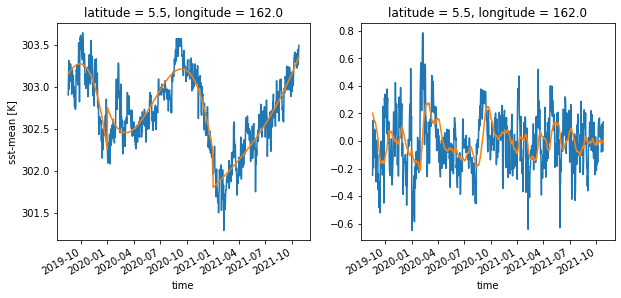

In [41]:
start = -800
latidx = -1
lonidx = 0
detrended, polyval = deseasonalize(warm,per_year=True, return_polyval=True)
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
warm[start:,latidx,lonidx].plot(ax = axes[0])
polyval[start:,latidx,lonidx].plot(ax = axes[0])
detrended[start:,latidx,lonidx].plot(ax = axes[1])
detrended[:,latidx,lonidx].rolling({'time':31}).mean()[start:].plot(ax = axes[1])

Per year removes interannual variability (rolling 3000 would result in nonesense). Trend is also removed. Intra-annual peaks are however still present, same timing as per_year=False

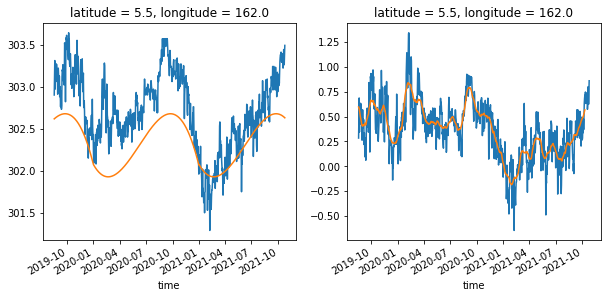

In [48]:
detrended, polyval = deseasonalize(warm,per_year=False, return_polyval=True, degree = 3)
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
warm[start:,latidx,lonidx].plot(ax = axes[0])
polyval[start:,latidx,lonidx].plot(ax = axes[0])
detrended[start:,latidx,lonidx].plot(ax = axes[1])
detrended[:,latidx,lonidx].rolling({'time':31}, center = True).mean()[start:].plot(ax = axes[1])

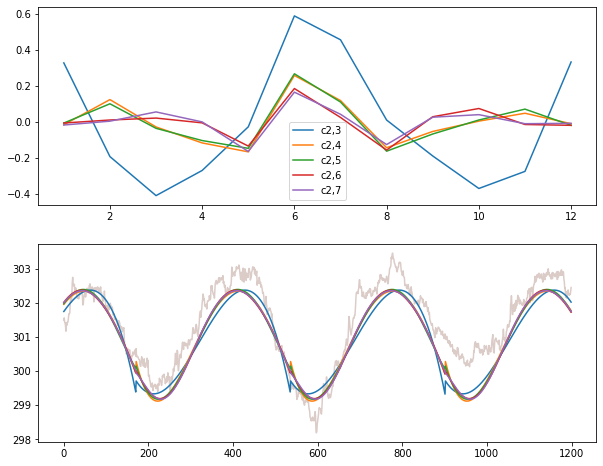

In [162]:
# Region cold2 seems to have most seasonal cycle.
fig, axes = plt.subplots(nrows = 2, figsize = (10,8))
for degree in [3,4,5,6,7]:
    #for key,field in components.items():
    key = 'c2'
    field = cold2
    ds, polyval = deseasonalize(field, per_year=False, return_polyval=True, degree = degree)
    spat = spatial_mean(ds)
    cycle = spat.groupby(spat.time.dt.month).mean()
    axes[0].plot(cycle.month, cycle.values, label = f'{key},{degree}')
    axes[1].plot(polyval[-1200:,0,-1])
axes[1].plot(field[-1200:,0,-1], zorder = 0, alpha = 0.3)
axes[0].legend()

Not a lot of difference beyond 4th order fitting. (response needs 5th order. see below)

Finding out the degree for OLR.

In [190]:
olr = da = xr.open_dataarray(eradir / 'olr_tropics.nc')

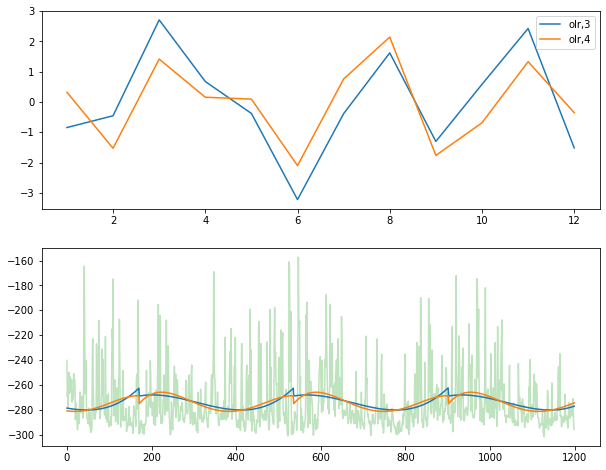

In [197]:
fig, axes = plt.subplots(nrows = 2, figsize = (10,8))
field = olr[:,-30:,:100]
for degree in [3,4]:  
    ds, polyval = deseasonalize(field, per_year=False, return_polyval=True, degree = degree)
    spat = spatial_mean(ds)
    cycle = spat.groupby(spat.time.dt.month).mean()
    axes[0].plot(cycle.month, cycle.values, label = f'olr,{degree}')
    axes[1].plot(polyval[-1200:,0,-1])
axes[1].plot(field[-1200:,0,-1], zorder = 0, alpha = 0.3)
axes[0].legend()

### Versions of the sst index, and properties
The mean(cold1,cold2) version proved most similar to the original predictor.

In [5]:
# Aggregation of time.
def makeindex(deseason = True, remove_interannual = True, timeagg: int = None):
    """ 
    Whether to deseason on the daily timescale and per gridpoint
    Remove interannual only relevant if deasonalizing
    Aggregation by time possible before constructing the index (left stamping)
    """
    components = {'w':warm.copy(),'c1':cold1.copy(),'c2':cold2.copy()}
    if deseason:
        for key,field in components.items():
            components[key] = deseasonalize(field,per_year=remove_interannual, return_polyval=False, degree = 4)
    if not (timeagg is None):
        for key,field in components.items():
            components[key] = agg_time(array = field, ndayagg = timeagg)
    #index = spatial_mean(components['w']) - np.stack([spatial_mean(components['c1']),spatial_mean(components['c2'])]).min(axis = 0)
    index = spatial_mean(components['w']) - np.stack([spatial_mean(components['c1']),spatial_mean(components['c2'])]).mean(axis = 0)
    return index

In [6]:
index = makeindex(deseason=False, remove_interannual=False)
index2 = makeindex(deseason = True, remove_interannual=False)
index3 = makeindex(deseason = True, remove_interannual=False, timeagg = 21)
index4 = makeindex(deseason = True, remove_interannual=True)
indices = {'1d_seas_inter':index, 
           '1d_deseas_inter':index2, 
           '21d_deseas_inter':index3, 
           '1d_deseas_deinter':index4, 
          }

Annual means not always meaningful. Big seasonal differences in the index. This need not result from remaining seasonality in the patches themselves.
Magnitude of seasonality after deseasonalizing is however low compared to overal std.

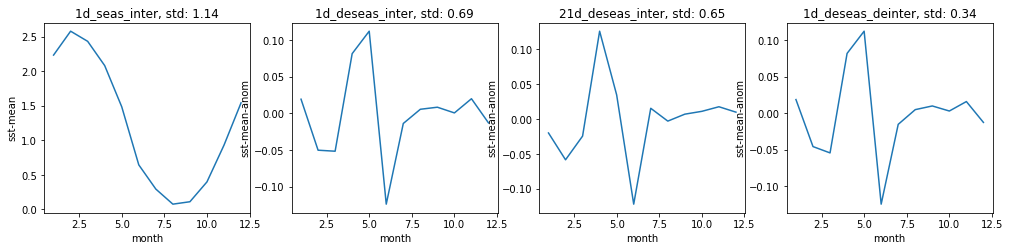

In [16]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (17,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    idx.groupby(idx.time.dt.month).mean().plot(ax = ax)
    ax.set_title(f'{key}, std: {np.round(float(idx.std()),2)}')

Trends are not very present even though the patches themselves still have mean warming (if not deseasonalized per year). Perhaps a sign of unreliable sst values that 1950-1970 seems to show reduced variability.

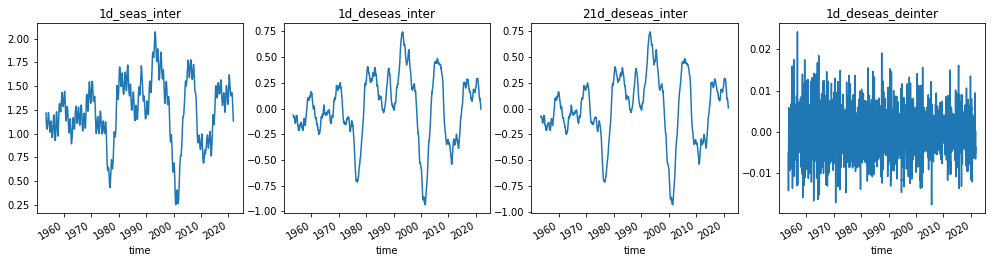

In [298]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (17,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    idx.rolling({'time':1200}).mean().plot(ax = ax)
    ax.set_title(key)

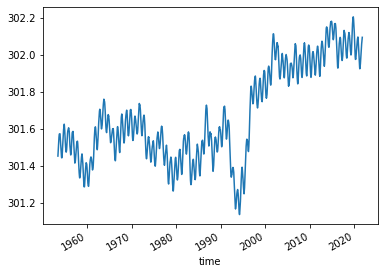

In [85]:
# here the warming trend in one of the patches. You also see seasonality in the patches of the equator (cold1 and cold2).
spatial_mean(cold1).rolling({'time':1200}).mean().plot()

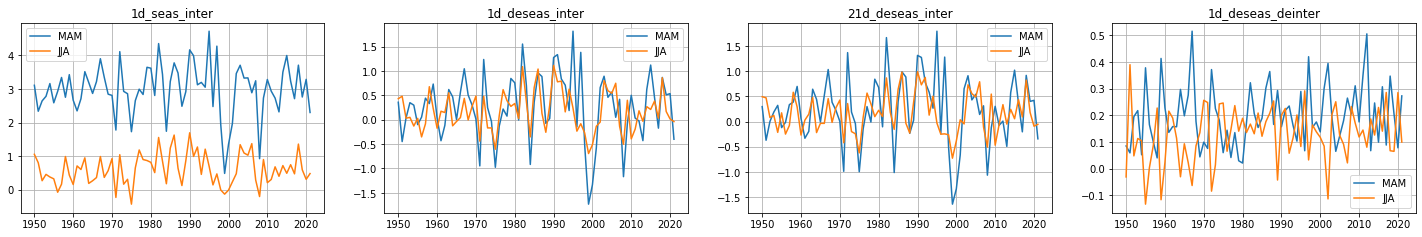

In [114]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (25,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    for season in ['MAM','JJA']:
        s = idx[idx.time.dt.season == season]
        s_yearly = s.groupby(s.time.dt.year).mean()
        ax.plot(s_yearly.year, s_yearly.values, label = season)
    ax.set_title(key)
    ax.legend()
    ax.grid(True)

Remarkable that in the latter case an anti-correlation seens to have formed. Other variables have anti-correlation only in the beginning of the timeseries. 
Also 21-day version (before index construction) is not dissimilar from the 1day version, in this seasonally aggregated vision.

#### Correspondence to covariance timeseries.

In [299]:
sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.models import map_foldindex_to_groupedorder

filepath = '/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
df = pd.read_parquet(filepath)
df = df.sort_index(axis =1)
# We must read fold 4, because this is the only one not using a large part of our data for training.
#order = map_foldindex_to_groupedorder(df, n_folds = 5) # strictly speaking fold 4 will remain fold 4

In [300]:
# These are pre-lagged
timeagg = 21
lag = -15
ssts = df.loc[:,(4,'sst_nhplus',timeagg,slice(None),lag,4,'spatcov')]

In [301]:
ssts_unlagged = ssts.copy().dropna()
ssts_unlagged.index = ssts_unlagged.index - pd.Timedelta(timeagg + abs(lag), unit ='D')

In [302]:
correlations = pd.DataFrame(np.nan, index = indices.keys(), columns = ['pearson','spearman'])
for key,idx in indices.items():
    subset = idx.to_pandas().loc[ssts_unlagged.index]
    correlations.loc[key,'pearson'] = pearsonr(subset.values,ssts_unlagged.values.squeeze())[0]
    correlations.loc[key,'spearman'] = spearmanr(subset.values,ssts_unlagged.values.squeeze())[0]

In [165]:
correlations

,pearson,spearman
1d_seas_inter,0.504876,0.503117
1d_deseas_inter,0.867091,0.850240
21d_deseas_inter,0.932223,0.925201
1d_deseas_deinter,0.150877,0.140422


In [303]:
correlations

,pearson,spearman
1d_seas_inter,0.603546,0.594801
1d_deseas_inter,0.897683,0.879629
21d_deseas_inter,0.962036,0.952390
1d_deseas_deinter,0.148591,0.143815


This is good news. Apparently versions of the index corresponds well to the spatial covariance (in the 1981-2019 period at least). Interannual variability should not be removed. That much is clear.

4th order de-seasonalizing results in higher maximum correlations (0.93, instead of 0.9). That all is for the min(cold1, cold2). The index based on mean of the two seems to correspond even more (0.96 with 4th order fitting)

### Correspondence to ENSO index

In [182]:
nino = pd.read_hdf('/scistor/ivm/jsn295/paper4/nino_daily.h5')

In [183]:
nino4 = nino.loc[(slice(None),0),('nino',1,4,'mean')] # unlagged version.
nino4.index = nino4.index.droplevel(-1)
nino34 = nino.loc[(slice(None),0),('nino',1,34,'mean')] # unlagged version.
nino34.index = nino34.index.droplevel(-1)
nino3 = nino.loc[(slice(None),0),('nino',1,3,'mean')] # unlagged version.
nino3.index = nino3.index.droplevel(-1)

In [50]:
timeaggs = [1,21]
correlations = pd.DataFrame(np.nan, index = indices.keys(), columns = pd.MultiIndex.from_product([timeaggs, ['pearson','spearman']], names = ['timeagg','metric']))
for timeagg in timeaggs:
    enso = agg_time(nino4.to_xarray(), timeagg).to_series()
    for key,idx in indices.items():
        subset = idx.to_pandas().loc[enso.index]
        correlations.loc[key,(timeagg,'pearson')] = pearsonr(subset.values,enso.values.squeeze())[0]
        correlations.loc[key,(timeagg,'spearman')] = spearmanr(subset.values,enso.values.squeeze())[0]

In [51]:
correlations

timeagg                  1                   21          
metric              pearson  spearman   pearson  spearman
1d_seas_inter      0.332169  0.330119  0.326634  0.323598
1d_deseas_inter    0.624514  0.583651  0.619895  0.582260
21d_deseas_inter   0.638562  0.591300  0.658879  0.613892
1d_deseas_deinter  0.057045  0.056151  0.022475  0.024607

Clear that 21day index shows the greatest correspondance to the sst index, and this is increased a little bit if enso is aggregated to the same time scale. But match is far from perfect. Would be interesting if mismatch is concentrated in certain periods of time, or perhaps it is conditional on the enso state. Or perhaps related to mid-pacific variability.

Minima in the correlation do not seem to correspond to minima in the teleconnection. Probably just unrelated variability?

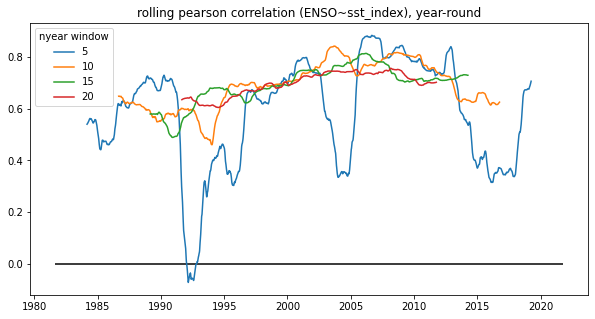

In [57]:
idxname = '21d_deseas_inter'
nino4.name = 'nino4'
combined = pd.merge(nino4, indices[idxname].to_series(), left_index = True, right_index = True, how = 'inner')
combined

fig, ax = plt.subplots(figsize = (10,5))
for nyears in [5,10,15,20]:
    test = combined.rolling(365*nyears, center = True).corr()
    test = test.loc[(slice(None),'sst-mean-anom'), 'nino4']
    test.index = test.index.droplevel(-1)
    ax.plot(test.index, test.values, label = str(nyears))
ax.hlines(y = 0, xmin = combined.index.min(), xmax = combined.index.max())
ax.legend(title = 'nyear window')
ax.set_title('rolling pearson correlation (ENSO~sst_index), year-round')
plt.show()


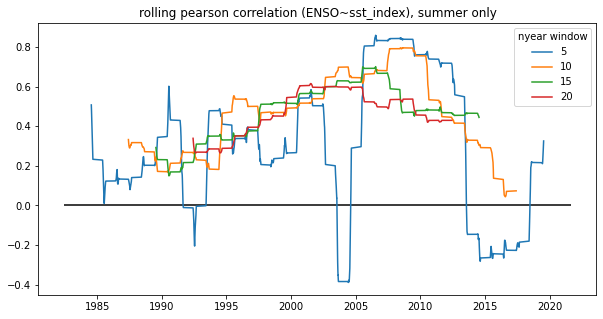

In [61]:
idxname = '21d_deseas_inter'
nino4.name = 'nino4'
combined = pd.merge(nino4, indices[idxname].to_series(), left_index = True, right_index = True, how = 'inner')
combined = combined.loc[combined.index.month.map(lambda m: m in [6,7,8]),:]

fig, ax = plt.subplots(figsize = (10,5))
for nyears in [5,10,15,20]:
    test = combined.rolling(92*nyears, center = True).corr()
    test = test.loc[(slice(None),'sst-mean-anom'), 'nino4']
    test.index = test.index.droplevel(-1)
    ax.plot(test.index, test.values, label = str(nyears))
ax.hlines(y = 0, xmin = combined.index.min(), xmax = combined.index.max())
ax.legend(title = 'nyear window')
ax.set_title('rolling pearson correlation (ENSO~sst_index), summer only')
plt.show()

Monthly Relative nino index to get a longer record, for compositing. 21day sst index, monthly (31day) ENSO values. Both are left-stamped.
No clear time dependence.

In [187]:
comb = pd.read_hdf('~/paper4/nino_rel_monthly.h5')
comb.index = pd.date_range(comb.index.values.min(), comb.index.values.max(), freq = 'MS') # Error with MS freq

In [37]:
ssts = indices['21d_deseas_inter'].to_series()
intersec = comb.index.intersection(ssts.index)
intersec_sum = intersec[intersec.month.map(lambda m: m in [6,7,8])]

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


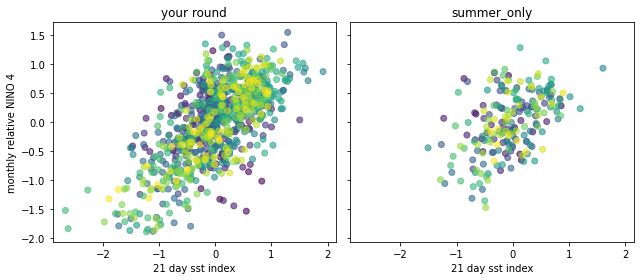

In [70]:
fig, axes = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (9,4))
axes[0].scatter(ssts.loc[intersec], comb.loc[intersec,('nino',31,4)], alpha = 0.6, c = intersec.to_julian_date())
axes[0].set_xlabel('21 day sst index')
axes[0].set_ylabel('monthly relative NINO 4')
axes[0].set_title('your round')
axes[1].scatter(ssts.loc[intersec_sum], comb.loc[intersec_sum,('nino',31,4)], alpha = 0.6, c = intersec_sum.to_julian_date())
axes[1].set_xlabel('21 day sst index')
axes[1].set_title('summer_only')
plt.tight_layout()
plt.show()

##### Enso properties
Enso in summer is less well defined.
Do I need to de-seasonalize enso or is only the variability related to the month? Not really.

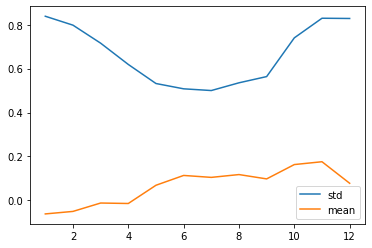

In [21]:
fig, ax = plt.subplots()
for m in ['std','mean']:
    gr = nino4.groupby(nino4.index.month)
    f = getattr(gr, m)
    val = f()
    ax.plot(val.index, val.values, label = m)
ax.legend()

## Creation of temperature target

In [7]:
subdomainlats = slice(40,56)
subdomainlons = slice(-5,24)
t2m = xr.open_dataarray(eradir / 't2m_europe.nc').sel(latitude = subdomainlats, longitude = subdomainlons)
clusterfield = xr.open_dataarray('/scistor/ivm/jsn295/clusters/t2m-q095.nc').sel(nclusters = 15, latitude = subdomainlats, longitude = subdomainlons)

In [65]:
t2manom, polyval = deseasonalize(t2m,per_year=False, return_polyval=True, degree = 3)

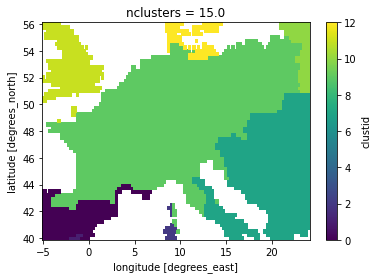

In [70]:
clusterfield.plot()

In [77]:
t2manom2, polyval2 = deseasonalize(t2m,per_year=False, return_polyval=True, degree = 4)

In [8]:
t2manom3, polyval3 = deseasonalize(t2m,per_year=False, return_polyval=True, degree = 5)

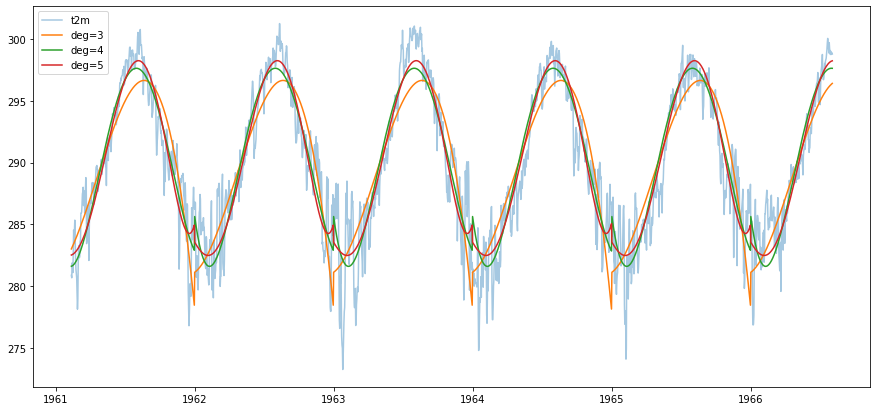

In [91]:
timeslice = slice(4000,6000) # indices
#timeslice = slice(14000,20000) # indices
fig, ax = plt.subplots( figsize = (15,7))
ax.plot(t2m[timeslice,0,-1].time, t2m[timeslice,0,-1].values, label = 't2m', alpha = 0.4)
ax.plot(t2m[timeslice,0,-1].time, polyval[timeslice,0,-1].values, label = 'deg=3')
ax.plot(t2m[timeslice,0,-1].time, polyval2[timeslice,0,-1].values, label = 'deg=4')
ax.plot(t2m[timeslice,0,-1].time, polyval3[timeslice,0,-1].values, label = 'deg=5')
ax.legend()

Not a very good fit with 3rd order polynomial. Temperatures are more peaked in summer. You can see that seasonal dependence keeps existing by looking at average residuals per month.

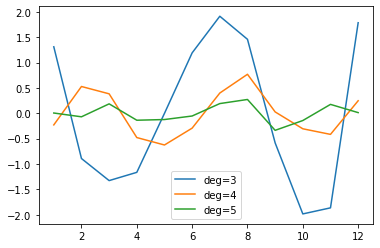

In [93]:
fig, ax = plt.subplots()
for data, degree in zip([t2manom,t2manom2,t2manom3], [3,4,5]):
    m = spatial_mean(data)
    s = m.groupby(m.time.dt.month).mean()
    ax.plot(s.month, s.values, label = f'deg={degree}')
ax.legend()

In [9]:
respagg = 31
reduced = t2manom3.groupby(clusterfield).mean('stacked_latitude_longitude')
reduced = reduced.sel(clustid = 9)
reduced = agg_time(reduced, ndayagg = respagg)

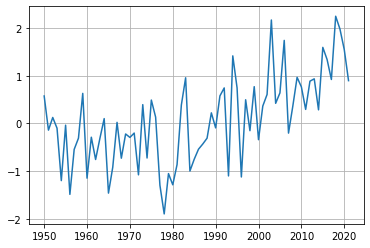

In [11]:
fig, ax = plt.subplots()
summer = reduced.loc[reduced.time.dt.season == 'JJA']
summermean = summer.groupby(summer.time.dt.year).mean()
ax.plot(summermean.year, summermean.values)
ax.grid(True)

Trend visible for the summer temperature anomalies (31day aggregation, left stamped.) Also heatwaves 2003, 2006, 2015, 2018, 2019, 2020.
#### Correspondence of this deaseasonalized version with original target
Original target only deseasonalized with climate of 1979-2019. For full period 1950-2019 the anomalies will thus have different means.

In [148]:
resp = pd.read_parquet('/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet').loc[:,(slice(None),respagg,9)]
resp_old = pd.read_parquet('/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.pre1981.parquet').loc[:,(slice(None),respagg,9)]

In [149]:
resp_joined = pd.concat([resp_old,resp]).iloc[:,0]
print(f'original mean {float(resp_joined.mean())}, new mean {float(reduced.mean())}')

original mean -0.33872510559770613, new mean -3.998967804363929e-05


In [150]:
print('pearson', pearsonr(resp_joined,reduced.loc[resp_joined.index]))
print('spearman', spearmanr(resp_joined,reduced.loc[resp_joined.index]))

pearson (0.9684017686452451, 0.0)
spearman SpearmanrResult(correlation=0.9643886340625786, pvalue=0.0)


Really high correspondence, which is very good. Similar timescale is of real importance (daily new, monthly original gives only 0.3 correlation).

### Running correlations between indices and new target.
Lagging by 15+21 days (for the left stamped 21day version at least). Period of stronger correlation is time dependend. For instance after 2000 you seem to get something comparable to the usable predictor in the earlier studies. Interestingly there seems to be periods of reversal.

In [74]:
timeagg = 21 # That is precursor timeagg
separation = -15

In [13]:
def lag_precursor(precursor: pd.Series, separation: int, timeagg: int):
    """timeagg = timeagg of the precursor"""
    lagged = precursor.copy()
    lagged.index = lagged.index + pd.Timedelta(abs(separation) + timeagg, unit = 'D')
    return lagged

def combine_index_response(idx, idxname, lag = True, separation = -15, only_months: list = None, detrend_response = False):
    """
    If summeronly then only summer values are used for detrending.
    """
    if not (type(idx) in [pd.Series, pd.DataFrame]):
        ids = idx.to_pandas()
        ids.name = idx.name
    else:
        ids = idx
    if idxname.startswith('21'):
        precursoragg = 21
    else:
        precursoragg = 1
    if lag:
        lagged = lag_precursor(ids, separation = separation, timeagg = precursoragg)
        lagged.name = ids.name
    else:
        lagged = ids
    response = reduced.to_pandas()
    response.name = reduced.name
    combined = pd.merge(lagged, response, left_index = True, right_index = True, how = 'inner')
    if not (only_months is None):
        combined = combined.loc[combined.index.month.map(lambda m: m in only_months),:]
    if detrend_response:
        combined.loc[:,response.name] = detrend(combined.loc[:,response.name])
    return combined


In [24]:
for key,idx in indices.items():
    combined = combine_index_response(idx = idx, idxname = key, lag = True, separation=15, only_months = [6,7,8], detrend_response = True)
    combined = combined.loc[slice('2000-01-01','2020-01-01'),:]
    print(key)
    print('pearson', pearsonr(combined.iloc[:,0], combined.iloc[:,1]))
    print('spearman', spearmanr(combined.iloc[:,0], combined.iloc[:,1]))

1d_seas_inter
pearson (0.3974203, 1.1431237667969398e-70)
spearman SpearmanrResult(correlation=0.39844754474969735, pvalue=4.669660799977448e-71)
1d_deseas_inter
pearson (0.3929471, 5.434953077394255e-69)
spearman SpearmanrResult(correlation=0.3922530515664834, pvalue=9.842390591068242e-69)
21d_deseas_inter
pearson (0.40396503, 3.608484847933003e-73)
spearman SpearmanrResult(correlation=0.4030599112915308, pvalue=8.063583076720173e-73)
1d_deseas_deinter
pearson (0.1033484, 8.911053689282802e-06)
spearman SpearmanrResult(correlation=0.11443090855273096, pvalue=8.593747472550396e-07)


TODO: how does correlation behave with leadtime? When detrended seems to drop with increasing lag. But decreasing lag not neccesarily.

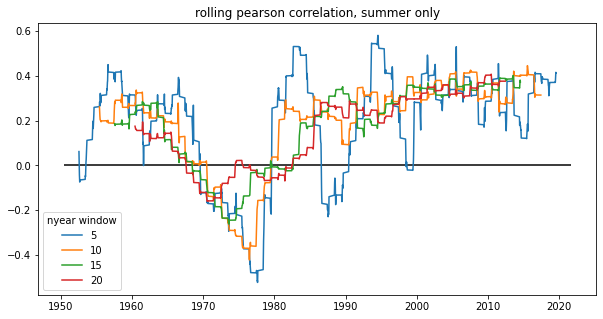

In [25]:
idxname = '21d_deseas_inter'
combined = combine_index_response(idx = indices[idxname], idxname = idxname, lag = True, only_months = [6,7,8], detrend_response = True)

fig, ax = plt.subplots(figsize = (10,5))
for nyears in [5,10,15,20]:
    test = combined.rolling(92*nyears, center = True).corr()
    test = test.loc[(slice(None),'t2m-mean-anom'),'sst-mean-anom']
    test.index = test.index.droplevel(-1)
    ax.plot(test.index, test.values, label = str(nyears))
ax.hlines(y = 0, xmin = combined.index.min(), xmax = combined.index.max())
ax.legend(title = 'nyear window')
ax.set_title('rolling pearson correlation, summer only')
plt.show()

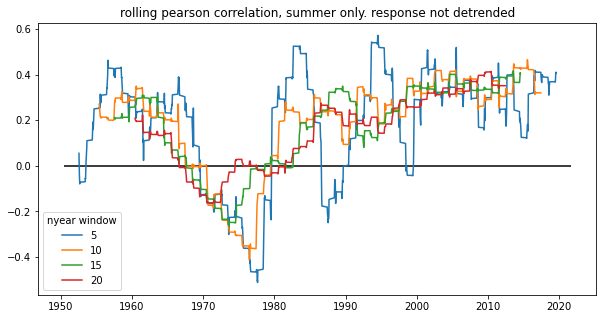

In [386]:
idxname = '21d_deseas_inter'
combined = combine_index_response(idx = indices[idxname], idxname = idxname, lag = True, only_months = [6,7,8], detrend_response = False)

fig, ax = plt.subplots(figsize = (10,5))
for nyears in [5,10,15,20]:
    test = combined.rolling(92*nyears, center = True).corr()
    test = test.loc[(slice(None),'t2m-mean-anom'),'sst-mean-anom']
    test.index = test.index.droplevel(-1)
    ax.plot(test.index, test.values, label = str(nyears))
ax.hlines(y = 0, xmin = combined.index.min(), xmax = combined.index.max())
ax.legend(title = 'nyear window')
ax.set_title('rolling pearson correlation, summer only. response not detrended')
plt.show()

Higher correlations occur after the year 2000

#### Behaviour in spring and with leadtime
June july correlation is highest. Spring correlation not neccesarily stronger.

In [26]:
# spring into summer
idxname = '21d_deseas_inter'

monthlists = [[month, month+1] for month in range(2,12)]
timeslices = [slice('1950-01-01','1970-01-01'),slice('1970-01-01','1980-01-01'),slice('1980-01-01','2000-01-01'),slice('2000-01-01','2021-01-01')]

correlations = []

for sl in timeslices:
    correlation = pd.DataFrame(np.nan, index = pd.MultiIndex.from_tuples(monthlists, names = ['month1','month2']), columns = ['pearson','spearman'])
    for monthlist in monthlists:
        combined = combine_index_response(idx = indices[idxname], idxname = idxname, lag = True, only_months = monthlist, detrend_response = False)
        comb = combined.loc[sl,:]
        correlation.loc[tuple(monthlist),'pearson'] = pearsonr(comb.iloc[:,0], comb.iloc[:,1])[0]
        correlation.loc[tuple(monthlist),'spearman'] = spearmanr(comb.iloc[:,0], comb.iloc[:,1])[0]
    correlations.append(correlation)

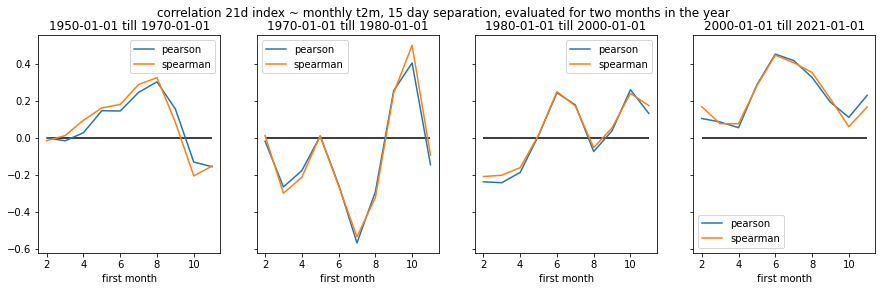

In [77]:
fig,axes = plt.subplots(ncols = len(timeslices), sharey=True, figsize = (15,4))
for i, sl in enumerate(timeslices):
    correlation = correlations[i]
    ax = axes[i]
    for cor in correlation.columns:
        ax.plot(correlation.index.get_level_values(0), correlation[cor], label = cor)
    ax.legend()
    ax.set_title(f'{sl.start} till {sl.stop}')
    ax.set_xlabel('first month')
    ax.hlines(0,2,11)
fig.suptitle('correlation 21d index ~ monthly t2m, 15 day separation, evaluated for two months in the year')
plt.show()

Spring connection certainly not the strongest. JJ seems to be the best. 1970-1980 period has this peculiar change from negative to positive.

In [198]:
# With leadtime, JJA
idxname = '21d_deseas_inter'
separations = list(range(0,405,5)) # in days
timeslices = [slice('1950-01-01','1970-01-01'),slice('1970-01-01','1980-01-01'),slice('1980-01-01','2000-01-01'),slice('2000-01-01','2021-01-01')]

correlations = []

for sl in timeslices:
    correlation = pd.DataFrame(np.nan, index = pd.Index(separations, name = 'sep'), columns = ['pearson','spearman'])
    for sep in separations:
        combined = combine_index_response(idx = indices[idxname], idxname = idxname, lag = True, 
                                          separation = sep, only_months = [6,7], detrend_response = True)
        comb = combined.loc[sl,:]
        correlation.loc[sep,'pearson'] = pearsonr(comb.iloc[:,0], comb.iloc[:,1])[0]
        correlation.loc[sep,'spearman'] = spearmanr(comb.iloc[:,0], comb.iloc[:,1])[0]
    correlations.append(correlation)

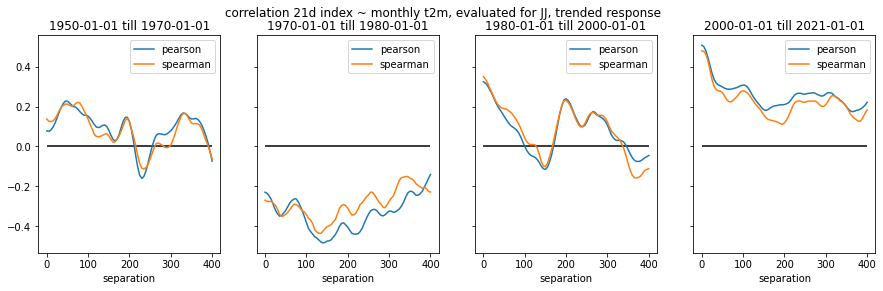

In [199]:
fig,axes = plt.subplots(ncols = len(timeslices), sharey=True, figsize = (15,4))
for i, sl in enumerate(timeslices):
    correlation = correlations[i]
    ax = axes[i]
    for cor in correlation.columns:
        ax.plot(correlation.index, correlation[cor], label = cor)
    ax.legend()
    ax.set_title(f'{sl.start} till {sl.stop}')
    ax.set_xlabel('separation')
    ax.hlines(0,min(separations),max(separations))
fig.suptitle('correlation 21d index ~ monthly t2m, evaluated for JJ, trended response')
plt.show()

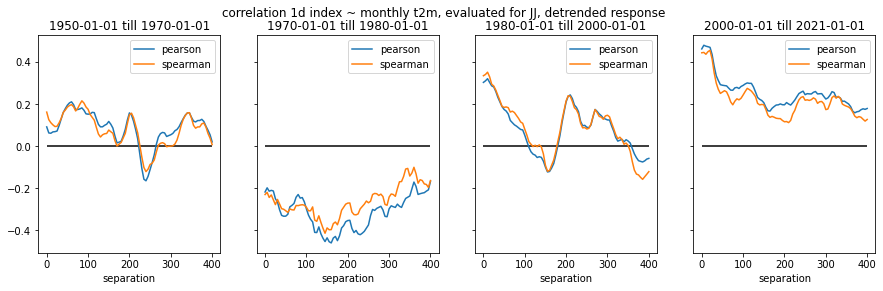

In [477]:
fig,axes = plt.subplots(ncols = len(timeslices), sharey=True, figsize = (15,4))
for i, sl in enumerate(timeslices):
    correlation = correlations[i]
    ax = axes[i]
    for cor in correlation.columns:
        ax.plot(correlation.index, correlation[cor], label = cor)
    ax.legend()
    ax.set_title(f'{sl.start} till {sl.stop}')
    ax.set_xlabel('separation')
    ax.hlines(0,min(separations),max(separations))
fig.suptitle('correlation 1d index ~ monthly t2m, evaluated for JJ, detrended response')
plt.show()

I find the 1970-1980 region a bit suspicious, as it does not close in to zero quickly, actually the negative correlation seems to increase with leadtime. Perhaps the period is really persistent.
Detrending does not really make a difference for this behavior.

### Matrix evaluation
Should this be combined with rolling time or different timeslices? Possibilities for the matrix:
* tercile categories (would show neg-neg anomalies in a different square as pos-pos)\
* median exceedence.
* or expected versus unexpected (neutral-neutral, neg-neg, pos-pos all expected) (unexpected would be periods of index reversal). (This is basically a derivative of the tercile matrix)

In [10]:
def digitize(combined_frame : pd.DataFrame, thresholds: pd.DataFrame):
    """
    shapes: frame (n_samples, n_variables), thresholds (nthresholds, n variables)
    """
    which_category = combined_frame.copy()
    for var in combined_frame.columns:
        which_category[var] = np.digitize(combined_frame[var], thresholds[var])
    return which_category

def count_combinations(digitized_array, normalize: bool = False):
    """
    Digitized array has e.g. 0,1,2 values for three terciles.
    returns count matrix. If normalized then frequencies (count/total)
    """
    nclasses = np.unique(digitized_array).max() + 1
    counts = pd.DataFrame(np.zeros((nclasses,nclasses)), 
                          index = pd.RangeIndex(nclasses, name = digitized_array.columns[0]), 
                          columns = pd.RangeIndex(nclasses, name = digitized_array.columns[1]))
    for i in range(len(digitized_array)):
        a,b = digitized_array.iloc[i,:]
        counts.iloc[a,b] += 1
    if normalize:
        counts = counts/counts.sum().sum()
    return counts

def split(digitized_frame: pd.DataFrame, to_split: pd.Series):
    """
    Split another series into subsets by means of the digitized combinations
    Groups of combinations (e.g. exceedence in one combined with exceedence in other)
    are extracted. Properties of the other series are computed with timestamps of the groups.
    """
    match = digitized_frame.index.intersection(to_split.index)
    if len(match) != len(digitized_frame.index):
        warnings.warn(f'to split series is {len(to_split.index) - len(digitized_frame.index)} longer than digitized combinations, only {match.min()} till {match.max()} can be used')
    splitted = digitized_frame.groupby(digitized_frame.columns.to_list()).apply(lambda x: to_split.loc[x.index.intersection(to_split.index)])
    return splitted

def split_compute(digitized_frame: pd.DataFrame, to_split: pd.Series):
    """
    Split another series into subsets by means of the digitized combinations
    Groups of combinations (e.g. exceedence in one combined with exceedence in other)
    are extracted. Properties of the other series are computed with timestamps of the groups.
    """
    splitted = split(digitized_frame = digitized_frame, to_split = to_split)
    means = splitted.groupby(splitted.index.names[:-1]).mean()
    stds = splitted.groupby(splitted.index.names[:-1]).std()
    return means.unstack(1), stds.unstack(1)

def split_index(digitized_frame: pd.DataFrame, to_split: pd.Series):
    """
    Split another series into subsets by means of the digitized combinations
    Groups of combinations (e.g. exceedence in one combined with exceedence in other)
    are extracted and for each the appropriate proportion of the to_split index is returned
    """
    splitted = split(digitized_frame = digitized_frame, to_split = to_split)
    timestamps = splitted.groupby(splitted.index.names[:-1]).apply(lambda s: s.index.get_level_values('time'))
    return timestamps

def visualize(tab: pd.DataFrame):
    fig, ax = plt.subplots(figsize = (4,3.5))
    im = ax.imshow(tab.values, vmin = 0, vmax = 1 / tab.shape[0], cmap = 'viridis', aspect = 'auto')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(tab.columns)))
    ax.set_xticklabels(tab.columns.to_flat_index().values, size = 12)
    ax.set_yticks(np.arange(len(tab.index)))
    ax.set_yticklabels(tab.index.to_flat_index().values, size = 12)
    ax.set_ylabel(tab.index.name)
    ax.set_xlabel(tab.columns.name)

    for i in tab.index:
        for j in tab.columns:
            ax.text(j,i,str(np.round(tab.loc[i,j],3)), horizontalalignment='center',verticalalignment='center',size = 14, color = 'white')
    return fig, ax

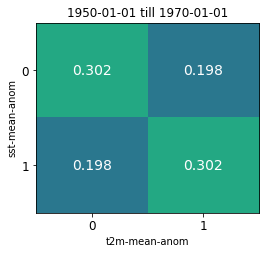

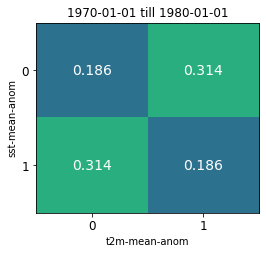

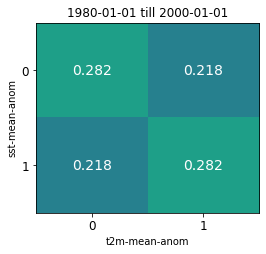

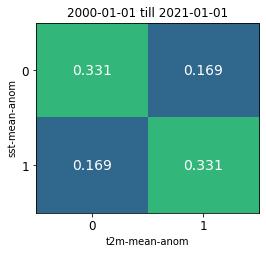

In [28]:
idxname = '21d_deseas_inter'

for sl in timeslices:
    combined = combine_index_response(idx = indices[idxname], idxname = idxname, 
                                  lag = True, separation = -15, only_months = [6,7,8], detrend_response = False)
    comb = combined.loc[sl,:]
    #thresholds = comb.quantile([0.33,0.66])
    thresholds = comb.quantile([0.5])
    counts = count_combinations(digitized_array=digitize(comb, thresholds=thresholds), normalize = True)
    fig, ax = visualize(counts)
    ax.set_title(f'{sl.start} till {sl.stop}')
    plt.show()

least clear link in 1980-2000. Symmetry for median confusion matrix happens because all axes are required to sum up to 0.5 in case of these median exceedences.

### Involvement of ENSO
two-way subsetting. First for the joined daily set from 1981 to may 2021.
#### Teleconnection presence -> ENSO

In [266]:
idxname = '21d_deseas_inter'
combined = combine_index_response(idx = indices[idxname], idxname = idxname, 
                                  lag = True, separation = -15, only_months = [6,7,8], detrend_response = False)

In [281]:
digits = digitize(combined, thresholds=combined.quantile([0.5]))
mean_nino4, s4 = split_compute(digits, to_split = lag_precursor(nino4,separation = -15, timeagg = 1))
mean_nino34, s34 = split_compute(digits, to_split = lag_precursor(nino34,separation = -15, timeagg = 1))
mean_nino3, s3 = split_compute(digits, to_split = lag_precursor(nino3,separation = -15, timeagg = 1))

mean_nino3m, _ = split_compute(digits.loc[slice('1982-06-16','2021-08-16'),:], to_split = lag_precursor(nino_m,separation = -15, timeagg = 31))

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: to split series is 8019 longer than digitized combinations, only 1982-06-01 00:00:00 till 2021-08-31 00:00:00 can be used
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: to split series is -1629 longer than digitized combinations, only 1982-06-16 00:00:00 till 2021-08-16 00:00:00 can be used


(<Figure size 288x252 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1553b6c6c5c0>)

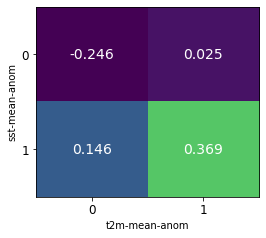

In [169]:
visualize(mean_nino4)

(<Figure size 288x252 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1553b6d5bef0>)

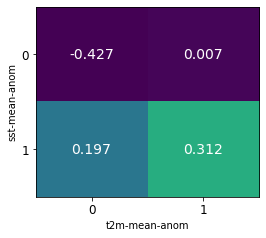

In [170]:
visualize(mean_nino34)

(<Figure size 288x252 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1553b64c7c50>)

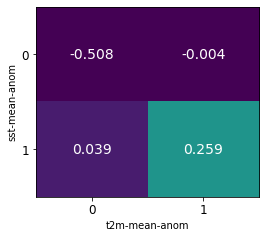

In [278]:
visualize(mean_nino3)

(<Figure size 288x252 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1553b69bb748>)

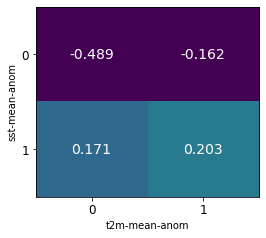

In [283]:
visualize(mean_nino3m) # Relative nino monthly instead of daily.

This seems to confirm the finding of earlier (histogram / composites) that the sets with strong connection have quite distinct ENSO states. (though it is still a mixture, with high standard deviation)
Missed responses (no links) have more neutral enso values. Within these two categories higher values for (1,0) than for (0,1) can come because the sst index itself is correlated with enso (0.6), so just more likely that enso is positive when sstanom is positive.

This graph kinda begs the question, is it not ENSO itself determining the temperature response? No, not totally, its correlation is lower than the 0.4 achieved with the sst index.

In [189]:
hist_nino4 = split(digits, to_split = lag_precursor(nino4,separation = -15, timeagg = 1))
hist_nino34 = split(digits, to_split = lag_precursor(nino34,separation = -15, timeagg = 1))
hist_nino3 = split(digits, to_split = lag_precursor(nino3,separation = -15, timeagg = 1))

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: to split series is 8019 longer than digitized combinations, only 1982-06-01 00:00:00 till 2021-08-31 00:00:00 can be used


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1553b738ebe0>,
      dtype=object)

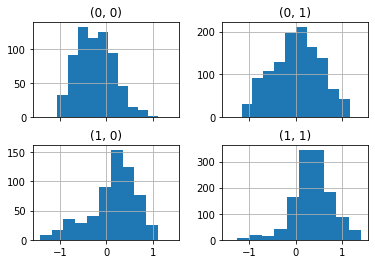

In [175]:
hist_nino4.unstack([0,1]).hist(sharex = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1553b6af6080>,
      dtype=object)

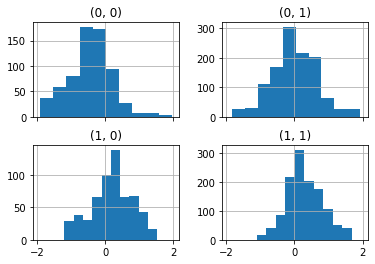

In [177]:
hist_nino34.unstack([0,1]).hist(sharex = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1553b67069e8>,
      dtype=object)

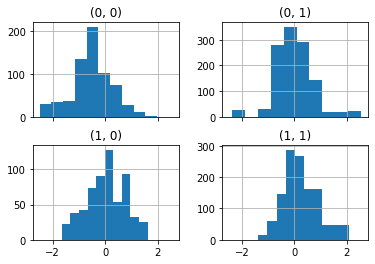

In [190]:
hist_nino3.unstack([0,1]).hist(sharex = True)

In [193]:
cnino = combine_index_response(idx = nino34, idxname = key, lag = True, separation=15, only_months = [6,7,8], detrend_response = True)

In [194]:
for sl in timeslices:
    print(sl, cnino.loc[sl].corr().iloc[0,1])
    print()

slice('1950-01-01', '1970-01-01', None) nan

slice('1970-01-01', '1980-01-01', None) nan

slice('1980-01-01', '2000-01-01', None) 0.17789458096328467

slice('2000-01-01', '2021-01-01', None) 0.19975223274040085



#### ENSO -> teleconnection strength
Now the other way of subsetting: classifying summers with persisting La Nina, versus transition La Nina. Help of Raed? Can do this with monthly data.

OND used because of peaking.

In [254]:
nino_m = pd.read_hdf('~/paper4/nino_rel_monthly.h5').loc[:,('nino',31,34,'mean')]
nino_m.index = pd.date_range(nino_m.index.values.min(), nino_m.index.values.max(), freq = 'MS')
nino_m = nino_m.loc[slice(None,'2022-05-30')]
nino_3m = nino_m.rolling(3, center = False).mean()[2:]
nino_3m.index = nino_m.index[:-2]  # Left stamping

In [260]:
winter_nino = nino_3m.loc[nino_3m.index.month == 10] # OND nino
ensos = pd.DataFrame({'preceding':winter_nino.shift(1).values,'center':winter_nino.values}, index = winter_nino.index.year)
ensos = ensos.dropna()
#+ 1 # December value valid for the upcoming year

In [261]:
threshold = 0.5
ensos['pnino'] = ensos['preceding'] > threshold
ensos['pnina'] = ensos['preceding'] < (-threshold)
ensos['cnina'] = ensos['center'] < (-threshold)
ensos['transition'] = np.logical_and(ensos['pnino'], ensos['cnina'])
#combined['transition'] = np.logical_and(np.logical_not(combined['pnina']), combined['cnina'])
ensos['persisting'] = np.logical_and(ensos['pnina'], ensos['cnina'])
ensos['other'] = np.logical_not(ensos['cnina'])

In [262]:
ensos.loc[ensos['persisting']]

,preceding,center,pnino,pnina,cnina,transition,persisting,other
1863,-0.712892,-0.559543,False,True,True,False,True,False
1864,-0.559543,-0.572585,False,True,True,False,True,False
1869,-0.629457,-1.256982,False,True,True,False,True,False
1870,-1.256982,-0.970544,False,True,True,False,True,False
1873,-1.214163,-0.601632,False,True,True,False,True,False
1874,-0.601632,-0.856600,False,True,True,False,True,False
1875,-0.856600,-0.923766,False,True,True,False,True,False
1879,-1.464253,-1.113772,False,True,True,False,True,False
1893,-1.291720,-1.066796,False,True,True,False,True,False
1894,-1.066796,-0.632636,False,True,True,False,True,False


In [258]:
idxname = '21d_deseas_inter'
combined = combine_index_response(idx = indices[idxname], idxname = idxname, 
                                  lag = True, separation = -15, only_months = [6,7,8], detrend_response = False)

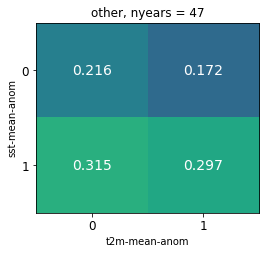

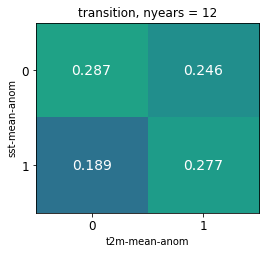

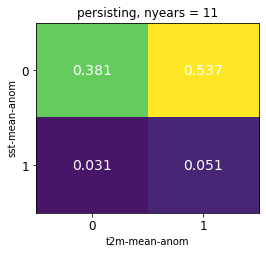

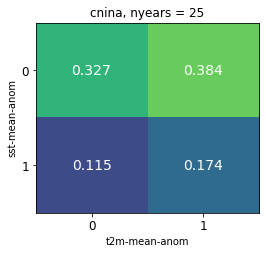

In [270]:
thresholds = combined.quantile([0.5])
for col in ['other','transition','persisting','cnina']:
    yearset = ensos.loc[ensos[col]].index
    subset = combined.loc[combined.index.year.map(lambda d: d in yearset),:]
    #thresholds = subset.quantile([0.5])
    counts = count_combinations(digitized_array=digitize(subset, thresholds=thresholds), normalize = True)
    fig, ax = visualize(counts)
    ax.set_title(f'{col}, nyears = {len(subset.index.year.unique())}')

## Combining teleconnection presence absence with enso modulation
All in a rolling window framework. Monthly relative ENSO index, which is less susceptible to climate change and has a longer record. Potentially interpolated for more faithfull sampling.

In [251]:
idxname = '21d_deseas_inter'
interpolate = True
combined = combine_index_response(idx = indices[idxname], idxname = idxname, 
                                  lag = True, separation = -15, only_months = [6,7,8], detrend_response = False)
nino_m = pd.read_hdf('~/paper4/nino_rel_monthly.h5')
nino_m.columns = nino_m.columns.droplevel(['variable', 'timeagg', 'metric']) # Retain only info of the nino regions
nino_m.index = pd.date_range(nino_m.index.values.min(), nino_m.index.values.max(), freq = 'MS')

# Interpolate nino_m for better sampling based on daily exceedence classifications.
nino_m_interp = pd.DataFrame(np.nan, index = pd.date_range(nino_m.index.values.min(), nino_m.index.values.max(), freq = 'd'), columns = nino_m.columns)
for region in nino_m.columns:
    f = interp1d(nino_m.index.to_julian_date(), nino_m.loc[:,region].values, kind = 'linear')
    nino_m_interp.loc[:,region] = f(nino_m_interp.index.to_julian_date())
if interpolate:
    nino_m = nino_m_interp

In [16]:
quantiles = [0.5]
overall = count_combinations(digitized_array=digitize(combined, thresholds=combined.quantile(quantiles)))

In [ ]:
nyearslice = 20

startdate = combined.index.min() + pd.Timedelta(nyearslice/2 * 365, 'd') # Centered rolling loop
enddate = combined.index.max() - pd.Timedelta(nyearslice/2 * 365, 'd')
centerdates = pd.date_range(startdate, enddate)
centerdates = centerdates[centerdates.month.map(lambda m: m in [6,7,8])]
counts = pd.DataFrame(np.nan, index = centerdates, columns = overall.stack(0).index)
ensos = pd.DataFrame(np.nan, index = centerdates, columns = pd.MultiIndex.from_tuples([ind + (region,) for ind in counts.columns.to_flat_index() for region in nino_m.columns],
                                                                                     names = counts.columns.names + nino_m.columns.names))
for centerdate in centerdates:
    sl = slice(centerdate - pd.Timedelta(nyearslice/2 * 365, 'd'), centerdate + pd.Timedelta(nyearslice/2 * 365, 'd'))
    comb = combined.loc[sl,:] # combined contains only summer values.
    exceedences = digitize(comb, thresholds=comb.quantile(quantiles))
    count = count_combinations(digitized_array=exceedences)
    counts.loc[centerdate,:] = count.stack(0)
    
    enso_means, enso_std = split_compute(exceedences, to_split = lag_precursor(nino_m,separation = -15, timeagg = 31))
    ensos.loc[centerdate,:] = enso_means.stack().stack()

outdir = Path('/scistor/ivm/jsn295/paper4/analysis/')
counts.to_hdf(outdir / f'window_{nyearslice}yr_interpolate_{interpolate}.h5', key = 'counts')
ensos.to_hdf(outdir / f'window_{nyearslice}yr_interpolate_{interpolate}.h5', key = 'enso')

In [ ]:
nyearslice = 10

startdate = combined.index.min() + pd.Timedelta(nyearslice/2 * 365, 'd') # Centered rolling loop
enddate = combined.index.max() - pd.Timedelta(nyearslice/2 * 365, 'd')
centerdates = pd.date_range(startdate, enddate)
centerdates = centerdates[centerdates.month.map(lambda m: m in [6,7,8])]
counts = pd.DataFrame(np.nan, index = centerdates, columns = overall.stack(0).index)
ensos = pd.DataFrame(np.nan, index = centerdates, columns = pd.MultiIndex.from_tuples([ind + (region,) for ind in counts.columns.to_flat_index() for region in nino_m.columns],
                                                                                     names = counts.columns.names + nino_m.columns.names))
for centerdate in centerdates:
    sl = slice(centerdate - pd.Timedelta(nyearslice/2 * 365, 'd'), centerdate + pd.Timedelta(nyearslice/2 * 365, 'd'))
    comb = combined.loc[sl,:] # combined contains only summer values.
    exceedences = digitize(comb, thresholds=comb.quantile(quantiles))
    count = count_combinations(digitized_array=exceedences)
    counts.loc[centerdate,:] = count.stack(0)
    
    enso_means, enso_std = split_compute(exceedences, to_split = lag_precursor(nino_m,separation = -15, timeagg = 31))
    ensos.loc[centerdate,:] = enso_means.stack().stack()

outdir = Path('/scistor/ivm/jsn295/paper4/analysis/')
counts.to_hdf(outdir / f'window_{nyearslice}yr_interpolate_{interpolate}.h5', key = 'counts')
ensos.to_hdf(outdir / f'window_{nyearslice}yr_interpolate_{interpolate}.h5', key = 'enso')

In [252]:
nyearslice = 20
interpolate = True
quantiles = [0.5]
enso_region = 34
outdir = Path('/scistor/ivm/jsn295/paper4/analysis/')
counts = pd.read_hdf(outdir / f'window_{nyearslice}yr_interpolate_{interpolate}.h5', key = 'counts')
ensos = pd.read_hdf(outdir / f'window_{nyearslice}yr_interpolate_{interpolate}.h5', key = 'enso').loc[:,(slice(None),slice(None),enso_region)]

# Construct matrix uncertainty band. Sampling full seasons
nrepeats = 100
bounds = pd.DataFrame(np.nan, index = pd.RangeIndex(nrepeats), columns = ['diag','crossdiag'])
for i in range(nrepeats): 
    sampled_years = np.random.randint(low = combined.index.year.min(), high = combined.index.year.max(), size = nyearslice)
    draw = combined.loc[combined.index.year.map(lambda y: y in sampled_years),:]
    dummy_matrix = count_combinations(digitize(draw,thresholds = draw.quantile(quantiles)))
    bounds.iloc[i,:] = dummy_matrix.iloc[0,:].values

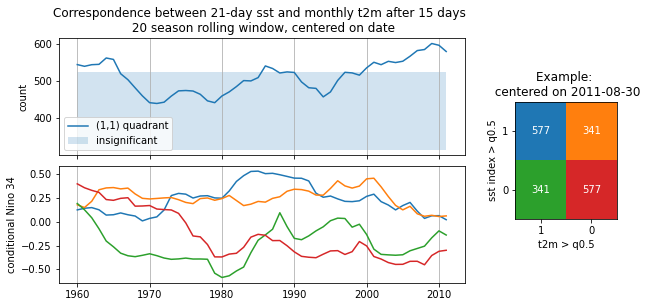

In [253]:
fig = plt.figure(figsize=(10,4.5),facecolor='white')

gs = GridSpec(nrows = 4, ncols=4, wspace=0.5)
ax1 = fig.add_subplot(gs[:2,:-1])
ax2 = fig.add_subplot(gs[2:,:-1])
ax3 = fig.add_subplot(gs[1:3,-1])

diag_11 = counts.groupby(counts.index.year).mean().loc[:,(1,1)]
ensos_year = ensos.groupby(counts.index.year).mean()
ax1.set_title(f'Correspondence between 21-day sst and monthly t2m after 15 days \n {nyearslice} season rolling window, centered on date')
ax1.plot(diag_11.index, diag_11.values, label = '(1,1) quadrant')
ax1.set_ylabel('count')
ax1.grid(axis = 'x')
ax1.set_xticklabels('')
ax1.fill_between(diag_11.index, y1 = bounds['diag'].quantile([0.05]), y2 = bounds['diag'].quantile([0.95]), alpha = 0.2, label = 'insignificant')
ax1.legend()

ax3.set_xlim((1.5,-0.5))
ax3.set_ylim((-0.5,1.5))
ax3.set_yticks([0,1])
ax3.set_ylabel('sst index > q0.5')
ax3.set_xlabel('t2m > q0.5')
ax3.set_title(f'Example: \n centered on {counts.index[-2].strftime("%Y-%m-%d")}')
for sst, t2m in counts.columns[::-1]:
    val = counts.loc[:,(sst,t2m)].iloc[-2]
    ax3.barh(width = 1, height = 1, left = t2m-0.5, y = sst)
    ax3.text(x = t2m,y = sst, s = int(val),horizontalalignment='center', verticalalignment='center', color = 'white')
    ax2.plot(ensos_year.index, ensos_year.loc[:,(sst,t2m)])
ax2.set_ylabel(f'conditional Nino {enso_region}')
ax2.grid(axis = 'x')
plt.show()

### Teleconnection presence and absence composites of other variables.
Plotting needs cartopy so write files and plot on a different machine.

Currently a composite of daily values, taken at the last moment before the separation gap

In [337]:
separation = -15
idxname = '21d_deseas_inter'
combined = combine_index_response(idx = indices[idxname], idxname = idxname, 
                                  lag = True, separation = -15, only_months = [6,7,8], detrend_response = False)

timeslices = [slice('1950-01-01','1970-01-01'),slice('2000-01-01','2021-01-01')]

In [343]:
compvar = 'z300_nhnorm'
anom = False

outdir = Path('~/paper4/analysis/composites')

if anom:
    basedir = Path('~/paper4/anomalies/')
else:
    basedir = Path('~/ERA5')
    
da = xr.open_dataarray(basedir / f'{compvar}{".anom.deg4" if anom else ""}.nc')
timestamps= da.coords['time'].to_pandas()

for sl in timeslices:
    comb = combined.loc[sl,:]
    thresholds = comb.quantile([0.5])
    digits = digitize(comb, thresholds=thresholds)
    ts = timestamps.loc[sl]
    subsets = split_index(digits, ts)
    comps = []
    for ind in subsets:
        laggedind = ind - pd.Timedelta(abs(separation), unit='D')
        comps.append(da.sel(time = laggedind).mean('time'))
    comps = xr.concat(comps,dim = subsets.index).unstack('concat_dim')
    comps.attrs.update({'nsamples':str(subsets.index.names) + str(subsets.map(lambda a: len(a)).to_dict()), 'units':da.units})
    outname = f'{sl.start}_{sl.stop}_{compvar}{"_anom" if anom else ""}.nc'
    comps.to_netcdf(outdir / outname)

#### Visualization

In [2]:
import cartopy.crs as ccrs


def data_for_pcolormesh(array, shading:str):
    """Xarray array to usuable things"""
    lats = array.latitude.values # Interpreted as northwest corners (90 is in there)
    lons = array.longitude.values # Interpreted as northwest corners (-180 is in there, 180 not)
    if shading == 'flat':
        lats = np.concatenate([lats[[0]] - np.diff(lats)[0], lats], axis = 0) # Adding the sourthern edge 
        lons = np.concatenate([lons, lons[[-1]] + np.diff(lons)[0]], axis = 0)# Adding the eastern edge (only for flat shating)
    return lons, lats, array.values.squeeze()


In [3]:
datapath = Path('/nobackup/users/straaten/paper4/analysis/composites/')

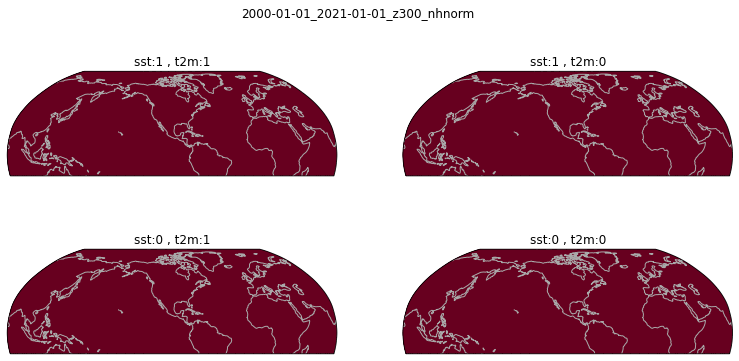

In [4]:
#filename = '2000-01-01_2021-01-01_olr_tropics_anom'
#filename = '2000-01-01_2021-01-01_sst_nhplus_anom'
#filename = '1950-01-01_1970-01-01_sst_nhplus_anom'
filename = '2000-01-01_2021-01-01_z300_nhnorm'

file = xr.open_dataarray(datapath / f'{filename}.nc')
proj_crs = ccrs.Robinson(central_longitude=-100)
#proj_crs = ccrs.Orthographic(central_longitude=0, central_latitude=90.0)
array_crs = ccrs.PlateCarree()
shading = 'flat'
vmax = 2

fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, ncols = 2, nrows = 2, squeeze = True, figsize = (13,6), facecolor = 'white')
fig.suptitle(filename)

for sst_y, t2m_x in itertools.product(file.coords['sst-mean-anom'].values,file.coords['t2m-mean-anom'].values):
    ax = axes[1- sst_y, 1- t2m_x]
    ax.set_title(f'sst:{sst_y} , t2m:{t2m_x}')
    pattern = file.loc[:,:,sst_y,t2m_x]
    im = ax.pcolormesh(*data_for_pcolormesh(pattern, shading = shading), zorder = 1, shading = shading, 
              transform = array_crs, cmap = 'RdBu_r',vmin = 0,vmax = 1500)
    ax.coastlines(zorder = 2, lw = 1, color = 'darkgrey')

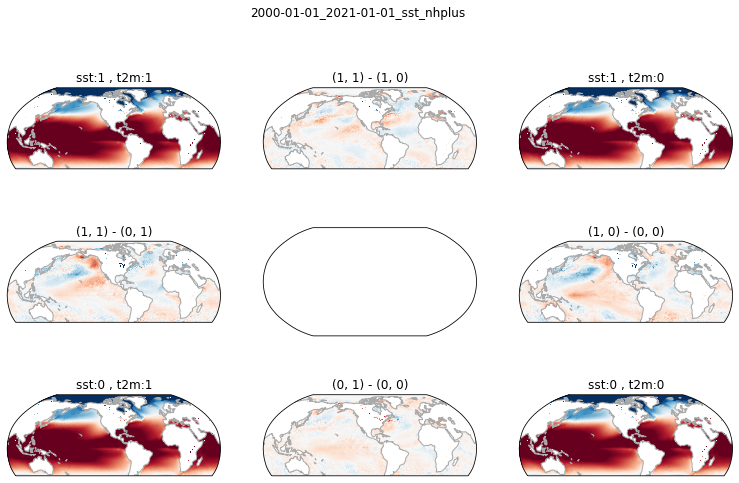

In [47]:
# Version with difference plots.
filename = '2000-01-01_2021-01-01_sst_nhplus'
#filename = '2000-01-01_2021-01-01_z300_nhnorm'

file = xr.open_dataarray(datapath / f'{filename}.nc')
proj_crs = ccrs.Robinson(central_longitude=-100)
#proj_crs = ccrs.Orthographic(central_longitude=0, central_latitude=90.0)
array_crs = ccrs.PlateCarree()
shading = 'flat'

normmin, normmax = 275, 300
diffmin, diffmax = -2, 2

#normmin, normmax = 90000, 96000
#diffmin, diffmax = -800, 800

fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, ncols = 3, nrows = 3, squeeze = True, figsize = (13,8), facecolor = 'white')
fig.suptitle(filename)

plot_positions = pd.DataFrame({'x':[-1,0,-1,0],'y':[-1,-1,0,0]}, index = 
                              file.sel(latitude = 0,longitude = 0).coords.to_index(), columns = ['x','y'])

patterns = pd.Series(np.nan, index = plot_positions.index, dtype = object)

# Fill in the normal fields
for sst, t2m in itertools.product(file.coords['sst-mean-anom'].values,file.coords['t2m-mean-anom'].values):
    ax = axes[plot_positions.loc[(sst, t2m),'y'], plot_positions.loc[(sst, t2m),'x']]
    ax.set_title(f'sst:{sst} , t2m:{t2m}')
    pattern = file.loc[:,:,sst,t2m]
    patterns.loc[(sst,t2m)] = pattern
    im = ax.pcolormesh(*data_for_pcolormesh(pattern, shading = shading), zorder = 1, shading = shading, 
              transform = array_crs, cmap = 'RdBu_r',vmin = normmin,vmax = normmax)
    ax.coastlines(zorder = 2, lw = 1, color = 'darkgrey')
    
# Computing and plotting the difference fields.
for rowind, colind in [(0,1),(1,0),(1,-1),(-1,1)]:
    ax = axes[rowind, colind]
    selection = patterns.loc[np.logical_or(plot_positions['x'] == colind, plot_positions['y'] == rowind).values]
    assert len(selection.index) == 2
    ax.set_title(f'{selection.index[-1]} - {selection.index[0]}')
    difference = selection.iloc[-1] - selection.iloc[0]
    im = ax.pcolormesh(*data_for_pcolormesh(difference, shading = shading), zorder = 1, shading = shading, 
              transform = array_crs, cmap = 'RdBu_r',vmin = diffmin, vmax = diffmax)
    ax.coastlines(zorder = 2, lw = 1, color = 'darkgrey')